In [1]:
import pandas as pd

df = pd.read_csv('../datasets/processed_data.csv', on_bad_lines='skip')
output_dir = '../diagrams/classification'

In [2]:
# Definiamo gli intervalli (bins) e le etichette
bins = [0, 5000, 10000, 14000, 20000, float('inf')]  # Inf significa "tutto il resto sopra 20k"
labels = [
    '0-5000',
    '5000-10000',
    '10000-14000',
    '14000-20000',
    '20000+'
]

# Creiamo la colonna della classe
df['prezzo'] = pd.cut(df['prezzo'], bins=bins, labels=labels)

In [3]:
import matplotlib.pyplot as plt
def plot_bar_chart(df, target='prezzo'):
    counts = df[target].value_counts().sort_index()
    labels = counts.index.astype(str)

    plt.figure(figsize=(8, 5), facecolor='white')
    ax = plt.gca()
    ax.set_facecolor('white')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')

    plt.bar(labels, counts, color=['blue', 'green', 'orange', 'red', 'violet'])
    plt.title(f'Distribuzione delle classi di {target} (Bar Plot)')
    plt.xlabel(target)
    plt.ylabel('Frequenza')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig(output_dir + '/plot_bar_class_balancing.png')
    plt.show()


def plot_pie_chart(df, target='prezzo'):
    counts = df[target].value_counts().sort_index()
    labels = counts.index.astype(str)

    plt.figure(figsize=(6, 6), facecolor='white')
    wedges, texts, autotexts = plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=['blue', 'green', 'orange', 'red', 'violet'], startangle=140)

    for autotext in autotexts:
        autotext.set_color('white')

    plt.title(f'Distribuzione delle classi di {target} (Pie Chart)')
    plt.savefig(output_dir + '/pie_chart_class_balancing.png')
    plt.show()

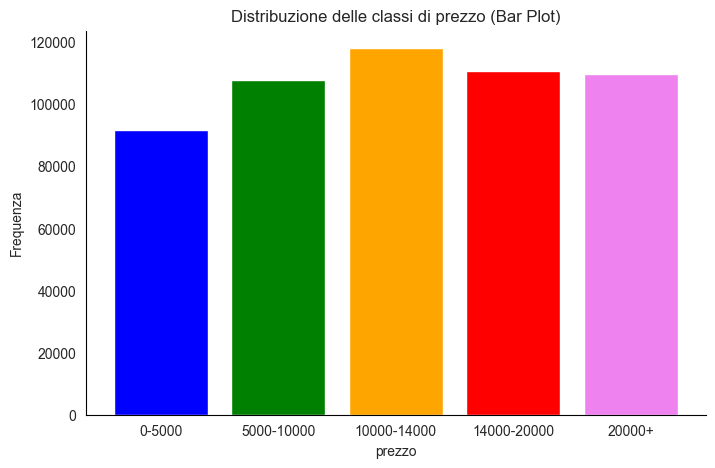

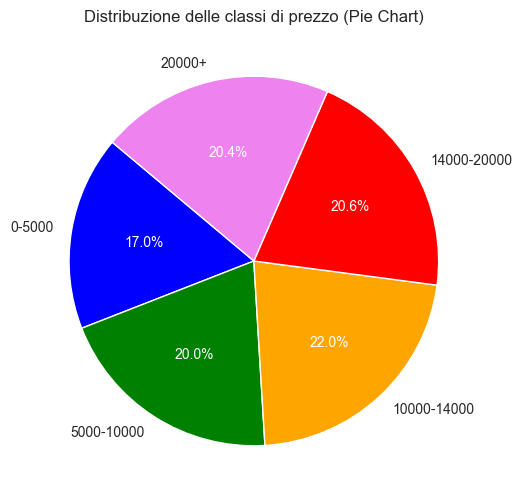

In [4]:
plot_bar_chart(df)
plot_pie_chart(df)

In [5]:
# Mappatura manuale delle classi
mapping = {
    '0-5000': 1,
    '5000-10000': 2,
    '10000-14000': 3,
    '14000-20000': 4,
    '20000+': 5
}
df['prezzo'] = df['prezzo'].map(mapping)
df['prezzo'] = df['prezzo'].astype(int)

In [6]:
from sklearn.model_selection import train_test_split
# Separazione in features e target
X = df.drop(columns=['prezzo'])
y = df['prezzo']

# Suddivisione in training e test con stratificazione
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


In [7]:
def data_preparation_train(X_train, y_train):
    calculate_modes_and_means(X_train)
    print("Shape before data_imputation:", X_train.shape[0])
    print("Shape of y_train:", y_train.shape[0])
    X_train = data_imputation(X_train)
    print("Shape after data_imputation:", X_train.shape[0])
    X_train = feature_engineer(X_train)
    print("Shape after feature_engineer:", X_train.shape[0])
    y_train = y_train[X_train.index]
    X_train = encode_train(X_train, y_train)
    X_train = normalize_train(X_train)
    X_train = remove_outliers(X_train)
    X_train = select_features_train(X_train)

    return X_train

In [8]:
def data_preparation_test(X_test):
    X_test = data_imputation(X_test)
    print("Shape before data_imputation:", X_test.shape[0])
    X_test = data_imputation(X_test)
    print("Shape after data_imputation:", X_test.shape[0])
    X_test = feature_engineer(X_test)
    print("Shape after feature_engineer:", X_test.shape[0])
    X_test = encode_test(X_test)
    X_test = normalize_test(X_test)
    X_test = select_features_test(X_test)

    return X_test

In [9]:
group_modes = {}
mean_condizione_by_anno = {}
mean_chilometraggio_by_anno = {}
mean_chilometraggio_by_eta = {}
mean_condizione_by_eta = {}
overall_modes = {}
overall_condizione_mean = None
overall_chilometraggio_mean = None

In [10]:
def calculate_modes_and_means(X_train):
    global group_modes, mean_condizione_by_anno, mean_chilometraggio_by_anno, mean_chilometraggio_by_eta, mean_condizione_by_eta, overall_modes, overall_condizione_mean, overall_chilometraggio_mean

    X = X_train.copy()
    group_modes['carrozzeria'] = X.groupby('modello')['carrozzeria'].agg(
        lambda x: x.mode()[0] if not x.mode().empty else None).to_dict()
    group_modes['trasmissione'] = X.groupby('modello')['trasmissione'].agg(
        lambda x: x.mode()[0] if not x.mode().empty else None).to_dict()
    group_modes['colorazione'] = X.groupby('marca')['colorazione'].agg(
        lambda x: x.mode()[0] if not x.mode().empty else None).to_dict()
    group_modes['colore interni'] = X.groupby('marca')['colore interni'].agg(
        lambda x: x.mode()[0] if not x.mode().empty else None).to_dict()
    group_modes['modello'] = X.groupby('marca')['modello'].agg(
        lambda x: x.mode()[0] if not x.mode().empty else None).to_dict()
    group_modes['marca'] = X.groupby('modello')['marca'].agg(
        lambda x: x.mode()[0] if not x.mode().empty else None).to_dict()

    # Calcola le medie per anno
    mean_condizione_by_anno = X.groupby('anno produzione')['condizione'].mean().to_dict()
    mean_chilometraggio_by_anno = X.groupby('anno produzione')['chilometraggio'].mean().to_dict()

    mean_condizione_by_eta = {
        2015 - anno: media for anno, media in mean_condizione_by_anno.items()
    }

    mean_chilometraggio_by_eta = {
        2015 - anno: media for anno, media in mean_chilometraggio_by_anno.items()
    }

    # Calcola le mode complessive e le medie dopo imputazione
    overall_modes = {
        'carrozzeria': X['carrozzeria'].mode()[0],
        'trasmissione': X['trasmissione'].mode()[0],
        'colorazione': X['colorazione'].mode()[0],
        'colore interni': X['colore interni'].mode()[0],
        'modello': X['modello'].mode()[0],
        'marca': X['marca'].mode()[0]
    }

    # Calcola le medie complessive dopo imputazione per anno
    temp_condizione = X['condizione'].fillna(X['anno produzione'].map(mean_condizione_by_anno))
    overall_condizione_mean = temp_condizione.mean()

    temp_chilometraggio = X['chilometraggio'].fillna(X['anno produzione'].map(mean_chilometraggio_by_anno))
    overall_chilometraggio_mean = temp_chilometraggio.mean()

In [11]:
def data_imputation(X_train):
    global group_modes, mean_condizione_by_anno, mean_chilometraggio_by_anno, mean_chilometraggio_by_eta, mean_condizione_by_eta, overall_modes, overall_condizione_mean, overall_chilometraggio_mean

    X = X_train.copy()

    # Drop delle righe dove sia "Marca" che "Modello" sono null
    X = X.dropna(subset=["marca", "modello"], how="all")


    if 'trasmissione' in X.columns:
        X['trasmissione'] = X['trasmissione'].fillna(X['modello'].map(group_modes['trasmissione'])).fillna(
            overall_modes['trasmissione'])

    # Applica l'imputazione basata sui gruppi
    X['marca'] = X['marca'].fillna(X['marca'].map(group_modes['marca'])).fillna(overall_modes['marca'])
    X['modello'] = X['modello'].fillna(X['modello'].map(group_modes['modello'])).fillna(overall_modes['modello'])

    X['carrozzeria'] = X['carrozzeria'].fillna(X['modello'].map(group_modes['carrozzeria'])).fillna(overall_modes['carrozzeria'])

    X['colorazione'] = X['colorazione'].fillna(X['marca'].map(group_modes['colorazione'])).fillna(overall_modes['colorazione'])
    X['colore interni'] = X['colore interni'].fillna(X['marca'].map(group_modes['colore interni'])).fillna(overall_modes['colore interni'])

    X['allestimento'] = X['allestimento'].fillna('base')

    if('anno produzione' not in X.columns):
        # Imputa condizione e chilometraggio
        X['condizione'] = X['condizione'].fillna(X['età'].map(mean_condizione_by_eta)).fillna(overall_condizione_mean)
        X['chilometraggio'] = X['chilometraggio'].fillna(X['età'].map(mean_chilometraggio_by_eta)).fillna(overall_chilometraggio_mean)
    else:
        X['condizione'] = X['condizione'].fillna(X['anno produzione'].map(mean_condizione_by_anno)).fillna(
            overall_condizione_mean)
        X['chilometraggio'] = X['chilometraggio'].fillna(X['anno produzione'].map(mean_chilometraggio_by_anno)).fillna(
            overall_chilometraggio_mean)


    return X

In [12]:
def feature_engineer(data):
    anno_rif = 2015
    data['età'] = anno_rif - data['anno produzione']
    data.drop(columns=['anno produzione'], inplace=True)

    return data


In [13]:
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
label_encoder = LabelEncoder()
catboost_encoder = ce.TargetEncoder(smoothing=15)
marca_means = None
global_mean = None
known_makes = None
known_models = None
cat_cols = None

In [14]:
def encode_train(X_train, y_train):
    global marca_means, global_mean, known_makes, known_models, cat_cols, label_encoder, catboost_encoder

    if 'trasmissione' in X_train.columns:
        #Codifica 'trasmissione' con LabelEncoder
        X_train['trasmissione'] = label_encoder.fit_transform(X_train['trasmissione'])

    # Colonne categoriche da codificare con CatBoostEncoder
    cat_cols = [col for col in X_train.select_dtypes(include=['object', 'category']).columns if col != 'trasmissione']

    # Fit CatBoostEncoder
    encoded = catboost_encoder.fit_transform(X_train[cat_cols], y_train)

    # Prepara sostituzioni per modelli non visti
    marca_means = X_train.join(y_train.rename('target')).groupby('marca')['target'].mean()
    global_mean = y_train.mean()
    known_makes = X_train['marca'].unique()
    known_models = X_train['modello'].unique()

    X_train[cat_cols] = encoded
    return X_train


In [15]:
def encode_test(X_test):
    global marca_means, global_mean, known_makes, known_models, cat_cols, label_encoder, catboost_encoder

    X = X_test.copy()

    if 'trasmissione' in X.columns:
        # Applica LabelEncoder a 'trasmissione'
        X['trasmissione'] = label_encoder.transform(X['trasmissione'])

    # Applica CatBoostEncoder alle altre colonne categoriche
    encoded = catboost_encoder.transform(X[cat_cols])

    # Gestisci modelli non presenti nel training set
    new_models_mask = ~X['modello'].isin(known_models)
    if new_models_mask.any():
        replacements = X.loc[new_models_mask, 'marca'].map(marca_means).fillna(global_mean)
        encoded.loc[new_models_mask, 'modello'] = replacements.values

    X[cat_cols] = encoded
    return X


In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numeric_cols = None

In [17]:
def normalize_train(X_train):
    global scaler, numeric_cols

    numeric_cols = X_train.select_dtypes(include=['number']).columns
    X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])

    return X_train


In [18]:
def normalize_test(X_test):
    global scaler, numeric_cols

    X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

    return X_test

In [19]:
def remove_outliers(X_train):
    threshold = 3
    numeric_cols = X_train.select_dtypes(include=['number']).columns
    z_scores = (X_train[numeric_cols] - X_train[numeric_cols].mean()) / X_train[numeric_cols].std()
    mask = (z_scores.abs() <= threshold).all(axis=1)
    return X_train[mask]


In [20]:
threshold_variance = 0.1
features_to_keep = None

In [21]:
def select_features_train(X_train):
    global threshold_variance, features_to_keep
    variances = X_train.var()
    features_to_keep = variances[variances > threshold_variance].index.tolist()

    return X_train[features_to_keep]


In [22]:
def select_features_test(X_test):
    global features_to_keep

    return X_test[features_to_keep]


In [23]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from collections import Counter

# Parametri del modello e della validazione
n_splits = 10  # Numero di fold per la cross-validation
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Creazione cartella output per salvare i risultati
outdir = "../diagrams/classification"
os.makedirs(outdir, exist_ok=True)

# Liste per memorizzare le metriche
all_metrics = []

# Iniziamo la cross-validation
for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    print(f"Fold {fold+1}/{n_splits}")

    # Suddivisione dei dati
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Data Preparation
    X_train = data_preparation_train(X_train, y_train)
    y_train = y_train.loc[X_train.index]
    X_test = data_preparation_test(X_test)
    y_test = y_test.loc[X_test.index]

    # Bilanciamento con SMOTE solo sul training set
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    print(f"Distribuzione dopo SMOTE: {Counter(y_train_resampled)}")

    # Definizione e training del modello
    model = RandomForestClassifier(
        criterion='gini',
        max_depth=20,
        n_estimators=300,
        min_samples_split=10,
        min_samples_leaf=4,
        max_features='sqrt',
        n_jobs=-1,
        random_state=20,
        bootstrap=True
    )

    model.fit(X_train_resampled, y_train_resampled)

    # Predizioni sui dati di test
    y_test_pred = model.predict(X_test)

    # Calcolo delle metriche di valutazione
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred, average='weighted')
    recall = recall_score(y_test, y_test_pred, average='weighted')
    f1 = f1_score(y_test, y_test_pred, average='weighted')

    # Salvataggio delle metriche
    all_metrics.append({
        "fold": fold+1,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    })

    print(f"Fold {fold+1} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    # Matrice di confusione
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f"Matrice di Confusione - Fold {fold+1}")
    plt.xlabel('Predizioni')
    plt.ylabel('Etichette Reali')
    plt.savefig(f"{outdir}/confusion_matrix_fold_{fold+1}.png")
    plt.close()

    # Feature Importance
    feature_importances = pd.DataFrame({"Feature": X_train.columns, "Importance": model.feature_importances_})
    feature_importances = feature_importances.sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", data=feature_importances.head(15))  # Prime 15 feature più importanti
    plt.title(f"Feature Importance - Fold {fold+1}")
    plt.savefig(f"{outdir}/feature_importance_fold_{fold+1}.png")
    plt.close()

# Salvataggio delle metriche in un file CSV
df_metrics = pd.DataFrame(all_metrics)
df_metrics.to_csv(os.path.join(outdir, "/results/classification_results.csv"), index=False)

print(f"Metriche salvate in {outdir}/resclassification_results.csv")

Fold 1/10
Shape before data_imputation: 483942
Shape of y_train: 483942
Shape after data_imputation: 483942
Shape after feature_engineer: 483942
Shape before data_imputation: 53772
Shape after data_imputation: 53772
Shape after feature_engineer: 53772
Distribuzione dopo SMOTE: Counter({5: 103508, 3: 103508, 4: 103508, 1: 103508, 2: 103508})
Fold 1 - Accuracy: 0.8081, Precision: 0.8082, Recall: 0.8081, F1: 0.8081
Fold 2/10
Shape before data_imputation: 483942
Shape of y_train: 483942
Shape after data_imputation: 483942
Shape after feature_engineer: 483942
Shape before data_imputation: 53772
Shape after data_imputation: 53772
Shape after feature_engineer: 53772
Distribuzione dopo SMOTE: Counter({5: 103503, 2: 103503, 4: 103503, 3: 103503, 1: 103503})
Fold 2 - Accuracy: 0.8099, Precision: 0.8097, Recall: 0.8099, F1: 0.8098
Fold 3/10
Shape before data_imputation: 483942
Shape of y_train: 483942
Shape after data_imputation: 483942
Shape after feature_engineer: 483942
Shape before data_imput

OSError: Cannot save file into a non-existent directory: '\results'

In [26]:
df_metrics.to_csv("../diagrams/classification/results/classification_results.csv", index=False)

In [ ]:
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE


X_train = data_preparation_train(X_train, y_train)
y_train = y_train.loc[X_train.index]
X_test = data_preparation_test(X_test)
y_test = y_test.loc[X_test.index]

def random_forest_evaluation_depth_classification(data, target_column='target'):
    """
    Valuta l'effetto della profondità degli alberi (max_depth) su RandomForestClassifier,
    applicando SMOTE per il bilanciamento delle classi prima del training.

    Parametri:
      - data: DataFrame contenente i dati.
      - target_column: Nome della colonna target (default 'target').
    """

    # Bilanciamento con SMOTE
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    train_accuracies = []
    val_accuracies = []
    depths = range(1, 40)

    for depth in depths:
        # Inizializzazione e training del modello
        model = RandomForestClassifier(
            max_depth=depth,         # Controlla la complessità del modello
            n_estimators=500,        # Bilanciamento tra performance e velocità
            min_samples_split=10,     # Riduce overfitting
            min_samples_leaf=4,      # Previene overfitting sulle foglie
            max_features='sqrt',     # Ottimizza il trade-off bias-variance
            n_jobs=-1,               # Usa tutti i core disponibili
            random_state=20,
            bootstrap=True,
            criterion = 'giny'
        )
        model.fit(X_train_resampled, y_train_resampled)

        # Calcolo dell'accuracy
        y_train_pred = model.predict(X_train_resampled)
        y_test_pred = model.predict(X_test)

        train_acc = accuracy_score(y_train_resampled, y_train_pred)
        val_acc = accuracy_score(y_test, y_test_pred)

        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

    # Tracciamento dei risultati
    plt.figure(figsize=(10, 6))
    plt.plot(depths, train_accuracies, label='Training Accuracy', marker='o', linestyle='--', color='blue')
    plt.plot(depths, val_accuracies, label='Validation Accuracy', marker='o', linestyle='-', color='red')
    plt.xlabel('Tree Depth')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy vs. Tree Depth')
    plt.legend()
    plt.grid(True)
    plt.show()

# Esegui la funzione con un DataFrame df
random_forest_evaluation_depth_classification(df)